In [1]:
#Import required packages
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#Load MNIST dataset
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


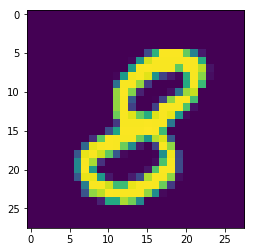

In [2]:
plt.imshow(mnist.train.images[5].reshape([28, 28]))
print(mnist.train.labels[5])

In [3]:
n_tr = mnist.train.images.shape[0]# number of training samples
n_ts = mnist.test.images.shape[0]#number of testing samples
n_pixel = mnist.train.images.shape[1]

## A Simple Feedforward Example 
Please refer to：https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

## Batch Nomalization For CNN Model

In [22]:
#Create weights
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.01)
  return tf.Variable(initial, name='weights')

#Create biases
def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial, name='biases')

In [23]:
#Convolutional function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#Max pool function
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [37]:
decay = 0.9
epsilon = 0.001
def conv_relu_pool(x, kernel_shape, bias_shape, is_training):
    # Create variable named "weights".
    weights = weight_variable(kernel_shape)
    # Create variable named "biases".
    biases = bias_variable(bias_shape)
    
    # Create two new parameters, gamma and beta (shift)
    #The bias for batch normalization
    gamma = tf.Variable(tf.ones(bias_shape))
    #
    beta = tf.Variable(tf.zeros(bias_shape))
    
    conv = conv2d(x, weights)    
    z = conv + biases
    
    moving_mean = tf.Variable(tf.zeros([z.get_shape()[-1]]), trainable=False)
    moving_var = tf.Variable(tf.ones([z.get_shape()[-1]]), trainable=False)
    axis = list(range(len(z.get_shape()) - 1))
    #If training
    if is_training:
        batch_mean, batch_var = tf.nn.moments(z, axis)
        train_mean = tf.assign(moving_mean,
                               moving_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(moving_var,
                              moving_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            bn = tf.nn.batch_normalization(z,
                                           batch_mean, batch_var, beta, gamma, epsilon)    
    else:
        bn = tf.nn.batch_normalization(z, moving_mean, moving_var, beta, gamma, epsilon)
    #Activation    
    relu = tf.nn.relu(bn)
    pool = max_pool_2x2(relu)
    return pool

In [76]:
def cnnLayer(x, keep_prob, is_training):
    x_image = tf.reshape(x, [-1,28,28,1])
    #First Conv
    with tf.name_scope('hidden1'):
        kernel_shape, bias_shape = [5, 5, 1, 32], [32] 
        h_pool1 = conv_relu_pool(x_image, kernel_shape, bias_shape, is_training)
        
    #Second Conv
    with tf.name_scope('hidden2'):
        kernel_shape, bias_shape = [5, 5, 32, 64], [64] 
        h_pool2 = conv_relu_pool(h_pool1, kernel_shape, bias_shape, is_training)
    
    #Fully Connected Layer
    with tf.name_scope('fully_connected'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #Softmax Layer
    with tf.variable_scope('softmax_layer'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return tf.nn.softmax(logits)

In [77]:
graph_cnn = tf.Graph()
with graph_cnn.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer(x, keep_prob, True)
    #Clip value in order to make it within(0, 1)
    y = tf.clip_by_value(y, 1e-10, 1.0)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    #Adam Optimizer
    train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    #Record the session
    saver = tf.train.Saver()


In [81]:
epochs = 5

batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(epochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                loss = sess.run(cross_entropy, feed_dict=feed_dict)
                print('Loss:', loss)
     #Save the model
    saved_model = saver.save(sess, 'temp/model.ckpt')

Loss: 128.267
Loss: 1.42754
Loss: 4.98711
Loss: 0.864103
Loss: 3.23103
Loss: 9.99138
Loss: 0.606274
Loss: 0.666505
Loss: 0.15103
Loss: 0.0298654


In [82]:
with graph_cnn.as_default() as g:
    #Set it as testing model
    y = cnnLayer(x, keep_prob, False)


In [83]:
with tf.Session(graph=graph_cnn) as sess:
    sess.run(tf.global_variables_initializer())
    #Restore the model
    ckpt = tf.train.get_checkpoint_state('temp')
    saver.restore(sess, ckpt.model_checkpoint_path)
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.test.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

INFO:tensorflow:Restoring parameters from temp\model.ckpt
Testing Accuracy： 0.9919


It seems with batcn normalization, the model improves rapidly.
Reference:

https://github.com/ry/tensorflow-resnet/blob/master/resnet.py

https://gist.github.com/tomokishii/0ce3bdac1588b5cca9fa5fbdf6e1c412

https://r2rt.com/implementing-batch-normalization-in-tensorflow.html